In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, plot_roc_curve, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
magnus_df = pd.read_pickle("./magnus.pkl")

magnus_df = magnus_df.drop(columns = ['opponent', 'opening_moves', 'opening_variant'])


In [3]:
magnus_df.rename(columns = {'player_color' : 'magnus_color', 'player_rating' : 'magnus_rating'}, inplace = True)

In [4]:
small_opening_list = magnus_df['opening'].value_counts()[magnus_df['opening'].value_counts() < 10].index
small_opening_list
magnus_df['opening'].isin(small_opening_list)

0       False
1       False
2       False
3       False
4       False
        ...  
3195    False
3196    False
3197    False
3198    False
3199    False
Name: opening, Length: 3200, dtype: bool

In [5]:
magnus_df = magnus_df[~magnus_df['opening'].isin(small_opening_list)]

In [6]:
X = magnus_df.drop(columns = 'result')
y = magnus_df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .3)

In [7]:
numeric_pipeline = Pipeline([('numimputer', SimpleImputer(strategy= 'mean')), ('numnorm', StandardScaler())])

ordinal_pipeline = Pipeline([
    ('ordimputer', SimpleImputer(strategy = 'most_frequent')), 
    ('ordnorm', StandardScaler())
    ])

nominal_pipeline = Pipeline([
    ('onehotimputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehotenc', OneHotEncoder(sparse = False, drop = 'first')), 
    ('onehotnorm', MaxAbsScaler())
])

In [8]:
numeric_cols = ['opponent_rating', 'magnus_rating', 'length']
ordinal_cols = ['year']
nominal_cols = ['magnus_color', 'opening']

In [9]:
ct = ColumnTransformer(transformers = 
    [("ordinal_pipe", ordinal_pipeline, ordinal_cols),
    ("nominal_pipe", nominal_pipeline, nominal_cols),
    ("numeric_pipe", numeric_pipeline, numeric_cols)]
)

In [10]:
k_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', KNeighborsClassifier())
])

In [11]:
k_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ordinal_pipe',
                                                  Pipeline(steps=[('ordimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordnorm',
                                                                   StandardScaler())]),
                                                  ['year']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                 

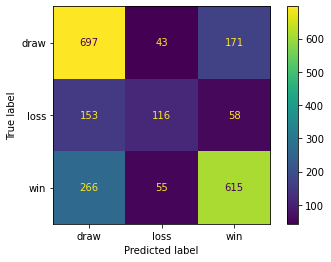

In [12]:
plot_confusion_matrix(k_pipe, X_train, y_train)

In [13]:
dtree_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', DecisionTreeClassifier())
])

In [14]:
dtree_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ordinal_pipe',
                                                  Pipeline(steps=[('ordimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordnorm',
                                                                   StandardScaler())]),
                                                  ['year']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                 

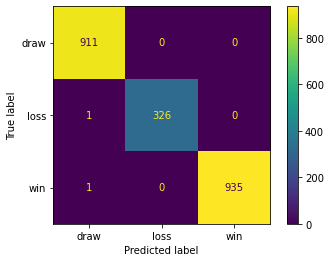

In [15]:
plot_confusion_matrix(dtree_pipe, X_train, y_train)

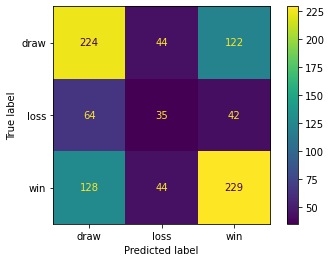

In [16]:
plot_confusion_matrix(dtree_pipe, X_test, y_test)

In [17]:
dtree_y_pred = dtree_pipe.predict(X_test)

In [18]:
accuracy_score(y_test, dtree_y_pred)

0.5236051502145923

In [19]:
randomforest_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', RandomForestClassifier())
])

In [20]:
randomforest_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ordinal_pipe',
                                                  Pipeline(steps=[('ordimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordnorm',
                                                                   StandardScaler())]),
                                                  ['year']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                 

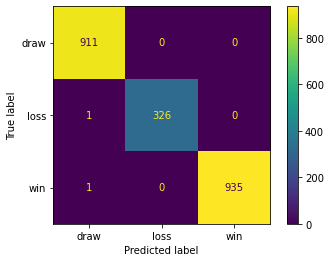

In [21]:
plot_confusion_matrix(randomforest_pipe, X_train, y_train)

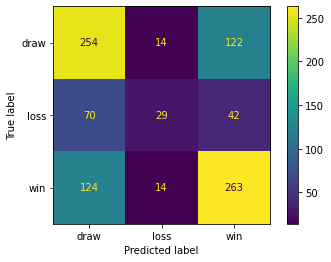

In [22]:
plot_confusion_matrix(randomforest_pipe, X_test, y_test)

In [23]:
randomforest_y_pred = randomforest_pipe.predict(X_test)

In [24]:
accuracy_score(randomforest_y_pred, y_test)

0.5858369098712446

In [25]:
dforest_pipe_grid = {'preprocessing__numeric_pipe__numimputer__strategy': ['mean', 'median'], 
                'model__n_estimators': np.arange(300, 1000, 100),
                'model__max_depth': np.arange(3, 25, 4),
                'model__criterion': ['gini', 'entropy'],
                }

In [26]:
randomforest_cv = GridSearchCV(estimator = randomforest_pipe, param_grid = dforest_pipe_grid, cv = 5)

In [27]:
randomforest_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('ordinal_pipe',
                                                                         Pipeline(steps=[('ordimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordnorm',
                                                                                          StandardScaler())]),
                                                                         ['year']),
                                                                        ('nominal_pipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(str

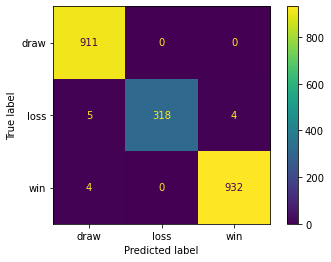

In [28]:
plot_confusion_matrix(randomforest_cv.best_estimator_, X_train, y_train)

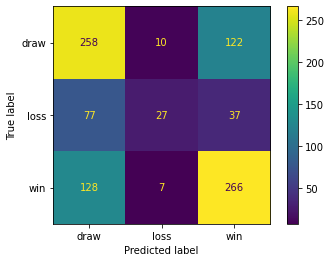

In [29]:
plot_confusion_matrix(randomforest_cv.best_estimator_, X_test, y_test)

In [30]:
print(classification_report(randomforest_cv.best_estimator_.predict(X_test), y_test))

              precision    recall  f1-score   support

        draw       0.66      0.56      0.60       463
        loss       0.19      0.61      0.29        44
         win       0.66      0.63      0.64       425

    accuracy                           0.59       932
   macro avg       0.51      0.60      0.51       932
weighted avg       0.64      0.59      0.61       932



In [31]:
randomforest_cv.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 19,
 'model__n_estimators': 600,
 'preprocessing__numeric_pipe__numimputer__strategy': 'mean'}

In [32]:
weight = pd.Series(randomforest_cv.best_estimator_['model'].feature_importances_)

In [33]:
randomforest_cv.best_estimator_['preprocessing']

ColumnTransformer(transformers=[('ordinal_pipe',
                                 Pipeline(steps=[('ordimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordnorm',
                                                  StandardScaler())]),
                                 ['year']),
                                ('nominal_pipe',
                                 Pipeline(steps=[('onehotimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotenc',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False)),
                                                 ('onehotnorm',
                                                  MaxAbsScaler())]),
                                 ['magnus_color', 'openin

In [34]:
hot_potato = OneHotEncoder(sparse = False, drop = 'first') 


In [35]:
openings_array = np.array(X_train['opening']).reshape(-1,1)

In [36]:
hot_potato.fit_transform(openings_array)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
opening_features = hot_potato.categories_
opening_features = opening_features[0][1:]
opening_features

array(['Benko Gambit Fully-Accepted', 'Benoni Defense',
       "Bishop's Opening", 'Bogo-Indian Defense', 'Caro-Kann Defense',
       'Catalan Opening', 'Dutch Defense', 'English Opening',
       'Four Knights Game', 'French Defense', 'Giuoco Piano Game',
       'Grünfeld Defense', 'Indian Game', 'Italian Game',
       "King's Fianchetto Opening", "King's Indian Attack",
       "King's Indian Defense", 'London System', 'Modern Defense',
       'Modern Defense with 1.e4', 'Nimzo-Indian Defense',
       'Nimzowitsch-Larsen Attack', "Petrov's Defense", 'Pirc Defense',
       "Queen's Gambit Declined", "Queen's Indian Defense",
       "Queen's Pawn Opening", 'Ruy López Opening', 'Réti Opening',
       'Scandinavian Defense', 'Scotch Game', 'Semi-Slav Defense',
       'Sicilian Defense', 'Slav Defense', 'Torre Attack',
       'Trompowsky Attack'], dtype=object)

In [38]:
weight

0     0.117330
1     0.034336
2     0.002194
3     0.002194
4     0.002126
5     0.001859
6     0.006481
7     0.005314
8     0.002951
9     0.015608
10    0.003490
11    0.006506
12    0.007249
13    0.007727
14    0.009511
15    0.003731
16    0.001524
17    0.006016
18    0.009497
19    0.000900
20    0.004114
21    0.003124
22    0.011674
23    0.003836
24    0.006584
25    0.003614
26    0.013726
27    0.008161
28    0.005818
29    0.017681
30    0.008857
31    0.003588
32    0.003282
33    0.005723
34    0.020249
35    0.010220
36    0.002121
37    0.003919
38    0.246040
39    0.150303
40    0.220823
dtype: float64

In [39]:
cted_data = pd.DataFrame(ct.fit_transform(X_train))

In [40]:
cted_data

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,-0.979113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.054294,-0.557929,-0.667931
1,-1.851915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,-4.835860,-0.667931
2,-0.455431,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.847080,0.194987,-1.261029
3,0.591932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.633520,0.648448,-0.964480
4,-1.677355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.030357,-1.695859,1.763771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,-0.979113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.076051,-0.763270,-1.320338
2170,-0.280871,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888414,0.374660,2.297559
2171,-0.804552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.309735,-0.036021,0.221716
2172,0.068250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667965,0.776786,-0.845860


In [41]:
weight_columns = ['year', 'magnus_color']
weight_columns.extend(opening_features)
weight_columns.extend(['oponent_rating', 'magnus_rating', 'length'])

In [42]:
weight_columns

['year',
 'magnus_color',
 'Benko Gambit Fully-Accepted',
 'Benoni Defense',
 "Bishop's Opening",
 'Bogo-Indian Defense',
 'Caro-Kann Defense',
 'Catalan Opening',
 'Dutch Defense',
 'English Opening',
 'Four Knights Game',
 'French Defense',
 'Giuoco Piano Game',
 'Grünfeld Defense',
 'Indian Game',
 'Italian Game',
 "King's Fianchetto Opening",
 "King's Indian Attack",
 "King's Indian Defense",
 'London System',
 'Modern Defense',
 'Modern Defense with 1.e4',
 'Nimzo-Indian Defense',
 'Nimzowitsch-Larsen Attack',
 "Petrov's Defense",
 'Pirc Defense',
 "Queen's Gambit Declined",
 "Queen's Indian Defense",
 "Queen's Pawn Opening",
 'Ruy López Opening',
 'Réti Opening',
 'Scandinavian Defense',
 'Scotch Game',
 'Semi-Slav Defense',
 'Sicilian Defense',
 'Slav Defense',
 'Torre Attack',
 'Trompowsky Attack',
 'oponent_rating',
 'magnus_rating',
 'length']

In [43]:
weights = pd.DataFrame((weight_columns, weight)).T

In [44]:
weights

,0,1
0,year,0.11733
1,magnus_color,0.0343363
2,Benko Gambit Fully-Accepted,0.00219439
3,Benoni Defense,0.00219377
4,Bishop's Opening,0.00212629
5,Bogo-Indian Defense,0.00185881
6,Caro-Kann Defense,0.00648066
7,Catalan Opening,0.00531362
8,Dutch Defense,0.00295142
9,English Opening,0.0156078
